### 数据描述

NYC 311's mission is to provide the public with quick and easy access to all New York City government services and information while offering the best customer service. 

The agency responds to the request, addresses it, and then closes it.

In [1]:
from pyspark import SparkContext
sc = SparkContext()
from pyspark.sql import SQLContext
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType
from pyspark.sql import SparkSession
spark = SparkSession(sc) 
sqlContext = SQLContext(sc)
import pyspark.sql.functions as F

### 阅读数据

In [2]:
df = spark.read.csv('../data/311_Service_Request.csv', header = True)

### 处理重复


In [3]:
# DataFrame有哪些列
df.columns

['Unique Key',
 'Created Date',
 'Closed Date',
 'Agency',
 'Agency Name',
 'Complaint Type',
 'Descriptor',
 'Location Type',
 'Incident Zip',
 'Incident Address',
 'Street Name',
 'Cross Street 1',
 'Cross Street 2',
 'Intersection Street 1',
 'Intersection Street 2',
 'Address Type',
 'City',
 'Landmark',
 'Facility Type',
 'Status',
 'Due Date',
 'Resolution Description',
 'Resolution Action Updated Date',
 'Community Board',
 'Borough',
 'X Coordinate (State Plane)',
 'Y Coordinate (State Plane)',
 'Park Facility Name',
 'Park Borough',
 'School Name',
 'School Number',
 'School Region',
 'School Code',
 'School Phone Number',
 'School Address',
 'School City',
 'School State',
 'School Zip',
 'School Not Found',
 'School or Citywide Complaint',
 'Vehicle Type',
 'Taxi Company Borough',
 'Taxi Pick Up Location',
 'Bridge Highway Name',
 'Bridge Highway Direction',
 'Road Ramp',
 'Bridge Highway Segment',
 'Garage Lot Name',
 'Ferry Direction',
 'Ferry Terminal Name',
 'Latitude',


In [4]:
# 检查是否存在重复值
print('Count of rows: {0}'.format(df.count()))
print('Count of non-duplicated rows: {0}'.format(df.distinct().count()))

Count of rows: 300698
Count of non-duplicated rows: 300698


In [5]:
# 初步估计因为有Unique Key存在所以找不出重复值，因此试试处理部分行的重复值
# 因为同一件事务可能打了两次电话，导致unique key不一样，但实际上内容一样
nonduplicated_row_count = df.dropDuplicates(subset = [c for c in df.columns if c not in df.columns[:3]]).count()
print('Count of non-duplicated rows based on partial columns: {0}'.format(nonduplicated_row_count))

Count of non-duplicated rows based on partial columns: 300486


In [6]:
# 找出重复值后处理重复值
df = df.dropDuplicates(subset = [c for c in df.columns if c not in df.columns[:3]])
print('Count of rows after dealing with duplicates: {0}'.format(df.count()))

Count of rows after dealing with duplicates: 300486


### 处理NA值

In [7]:
# 第一步删去NA比例太大的列
# 计算每列的NA比例
column_na_percentage = []
for col in df.columns:
    column_na_percentage.append(df.select(col).na.drop().count()/nonduplicated_row_count)

In [8]:
# 查看各列NA比例
column_na_percentage

[1.0,
 1.0,
 0.99280166130868,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9995640395891988,
 0.9913074153205141,
 0.8522127486804709,
 0.8522127486804709,
 0.8360223105236184,
 0.8343583394900261,
 0.1459502272984432,
 0.1442995680331197,
 0.99063849896501,
 0.9913074153205141,
 0.0011614517814473885,
 0.9999933441158656,
 1.0,
 0.9999900161737985,
 1.0,
 0.9927251186411347,
 1.0,
 1.0,
 0.9882257409663012,
 0.9882257409663012,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999966720579329,
 0.9999966720579329,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0008086899223258322,
 0.0008086899223258322,
 0.0008086899223258322,
 0.0008086899223258322,
 0.0,
 6.655884134368989e-06,
 6.655884134368989e-06,
 0.9882257409663012,
 0.9882257409663012,
 0.9882257409663012]

In [9]:
# 去除掉NA比高的列
na_large_columns = []
na_threshold = 0.5
for col_index in range(len(df.columns)):
    if column_na_percentage[col_index] < na_threshold:
        na_large_columns.append(df.columns[col_index])
        
df = df.drop(*na_large_columns)

In [11]:
# 第二步去除掉所有带NA的行
df = df.dropna(how = 'any')
print('Count of rows after removing NA: {0}'.format(df.count()))

Count of rows after removing NA: 249201


### 处理离群值

In [14]:
# 因本数据无数字型数据,不处理

### 条形图

In [12]:
# 对'complain type'列进行汇总
# 算出'complain type'列每个元素的个数

COMPLAINTTYPE_element_count = df.select('Complaint Type')\
                                .rdd.flatMap(lambda Row: Row)\
                                .map(lambda type: (type, 1))\
                                .reduceByKey(lambda a, b: a + b)\
                                .collect()

In [13]:
# 将数据整理成matplot需要的格式
complain_types = []
COMPLAINTTYPE_count = []
for typ, count in COMPLAINTTYPE_element_count:
    complain_types.append(typ)
    COMPLAINTTYPE_count.append(count)

In [15]:
# 按count降序排列
import pandas as pd
pd_df = pd.DataFrame(list(zip(complain_types, COMPLAINTTYPE_count)), 
               columns =['type', 'count']).sort_values(by =['count'], ascending = False)

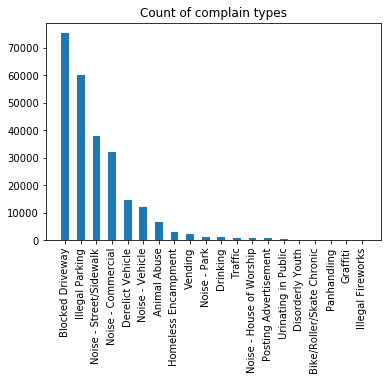

In [16]:
# 作图
from matplotlib import pyplot as plt
plt.bar(pd_df['type'], pd_df['count'], width = .5)
plt.title('Count of complain types')
plt.xticks(rotation= 90)
plt.show()